# Toxic Comment Dataset Challenge

Here I would be working on the Google Jigsaw Toxic Comment Classification challenge on Kaggle. Here is the link to the competition in Kaggle https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge. Some of the methods and practices that I would be using in this notebook are inspired by "Jeremy Howard" in his Kaggle notebook https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline and "Bongo" in https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras

## Question or problem definition.

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

The challenge requires us to create a model which predicts a probability of each type of toxicity for each comment. In this notebook I intend to try out a Naive-Bayes model using a bag-of-words model built using Tf-Idf vectorizer and to try out Keras to build a simple Keras model.

## Acquire training and testing data

Here we obtain the data from the dataset csv file by reading it into our Jupyter notebook

In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indic

In [2]:
train = pd.read_csv('toxic/train.csv')
test = pd.read_csv('toxic/test.csv')
subm = pd.read_csv('toxic/sample_submission.csv')

In [61]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [4]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
subm.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


From this command we should be able to find out if there are any null values in train or test set

In [6]:
train.isnull().any(), test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

## Wrangle, prepare, cleanse the data

Let us go ahead and get the comment text from the dataset and try to build a feature from the comments

In [7]:
comment_text = train['comment_text']
comment_text[0:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

## Analyze, identify patterns, and explore the data.

Let us analyze the comments text and see how they look in shape and size

In [8]:
lengths = train.comment_text.str.len()
lengths.mean(), lengths.std(), lengths.max()

(394.0732213246768, 590.7202819048923, 5000)

Let us plot the distribution of number of comments with the length of the comment

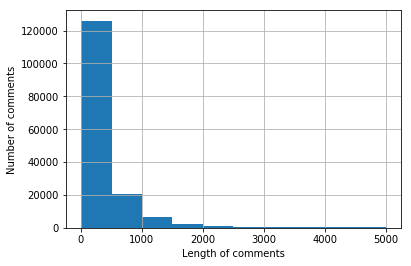

In [66]:
lengths.hist()
plt.ylabel('Number of comments')
plt.xlabel('Length of comments')
plt.show()

Here we can feature engineer another column 'None' to classify comments that are within the guidelines

In [10]:
cols = list(train.columns)
cols.remove('id')
cols.remove('comment_text')
train['none'] = 1-train[cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now let us see how big our training and test set are

In [11]:
len(train), len(test)

(159571, 153164)

This is to find out the classification for each comment and also wrangle the comments from the dataset

In [12]:
y = train[cols].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]
print(y[0])

[0 0 0 0 0 0]


## Visualize, report, and present the problem solving steps and final solution.

Here we would be using a tf-idf bag-of-words model to model the characters in the dataset. A TF-IDF vectorizer uses the term frequency and inverse document frequency to calculate the important of a term to the comment and overall importance. Here's a link to learn more about tf-idf http://www.tfidf.com/.

In order to extract the words from the comment and disregard all the punctuation in the comment, we would use regex and the string module in order to build the feature. 

The TfIdf vectorizer takes a comment and builds a feature for the words in the comment from the words that occur in the entire dataset.

In [13]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Now let us try build a word cloud for the first 200 comments on the dataset to see what words are used the most in the dataset. After that, we shall look into making the model fit into LogisticRegression models.

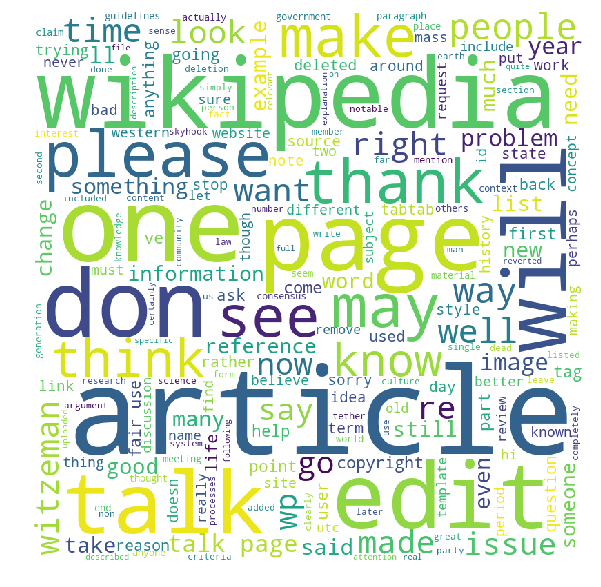

In [14]:
from wordcloud import WordCloud, STOPWORDS
 
comment_words = ' '
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in comments_train[0:200]:
     
    # typecaste each val to string
    val = str(val)
    tokens = tokenize(val.strip(string.punctuation))
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
         
    for words in tokens:
        comment_words = comment_words + words + ' '
 
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Here we would be using the Tfidf vectorizer to build our bag-of-words model. 

- ngram_range 
    - creates ngrams(weighted sequences of text of length (1,3). 
- Min_df and max_df. 
    - For the values to make sense heres the formula for inverse document frequency
        - IDF(t) = log_e(Total number of documents / Number of documents with term t in it). 
    - The log_e function should give a clue unto the value of the parameters min_df and max_df cut off idf values that are going to be larger than 3 and less than 0.9 in order to remove words that are:
        - insignificant in occurence
        - stopwords (words like 'at', 'a', 'in') that repeat too many items to be statistically significant

More information on the TF-IDF vectorizer is available at  http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [15]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,3), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_train = vec.fit_transform(train["comment_text"])
X_test = vec.transform(test["comment_text"])

Here let us define a probability function for a Naive Bayes model

In [16]:
def prob(y_i, y, x):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

## Model, predict and solve the problem.

Here we would be using LogisticRegression models to create binary classifiers for each feature that we have. 
C in the Regression models are inverse of regularization strength, smaller values specify stronger regularization, default value is 1.

In [17]:
def get_model(y):
    y = y.values
    r = np.log(prob(1,y, X_train) / prob(0,y, X_train))
    m = LogisticRegression(C=4)
    x_nb = X_train.multiply(r)
    return m.fit(x_nb, y), r

Let us initialize a empty array to store our predictions now

In [18]:
preds = np.zeros((len(test), len(cols)))

Here we are looking to train a binary LogisticRegression model to classify for each type of label and use that to predict the probabilities for the test set

In [19]:
for i, col in enumerate(cols):
    print('fit', col)
    m,r = get_model(train[col])
    preds[:,i] = m.predict_proba(X_test.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [20]:
subm_id = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([subm_id, pd.DataFrame(preds, columns = cols)], axis=1)
submission.to_csv('toxic/submission.csv', index=False)

## Supply or submit the results.

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import Sequential

In [47]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(comments_train))
list_tok_train = tokenizer.texts_to_sequences(comments_train)
list_tok_test = tokenizer.texts_to_sequences(comments_test)

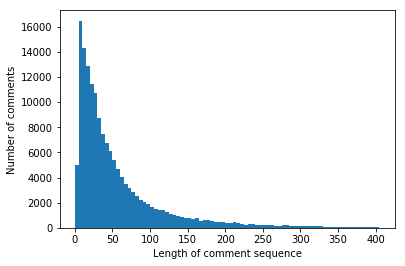

In [81]:
totalNumWords = [len(one_comment) for one_comment in list_tok_train]
plt.hist(totalNumWords,bins = np.arange(0,410,5))
plt.xlabel('Length of comment sequence')
plt.ylabel('Number of comments')
plt.show()

In [48]:
maxlen = 200
X_t = pad_sequences(list_tok_train, maxlen=maxlen)
X_te = pad_sequences(list_tok_test, maxlen=maxlen)

## Building a Keras LSTM model

Here we would be building a Keras LSTM model which is going to create a LSTM model for us to train this data on. Let us create the input layer for the model and build from here

In [59]:
embed_size = 128
hidden_layer = 60
dropout = 0.1
output_layer = 6

def buildModel(maxlen = 200, max_features = 20000, embed_size = 128, hidden_layer = 60, dropout = 0.1, output_layer = 6):
    model = Sequential()
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(hidden_layer, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(output_layer, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model
    
model = buildModel(maxlen, max_features, embed_size, hidden_layer, dropout, output_layer) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 60)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 366       
Total params: 2,605,726
Trainable params: 2,605,726
Non-trainable params: 0
_________________________________________________________________


In [60]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1275s 9ms/step - loss: 0.0729 - acc: 0.9767 - val_loss: 0.0508 - val_acc: 0.9818
Epoch 2/2
143613/143613 [==============================] - 1199s 8ms/step - loss: 0.0459 - acc: 0.9832 - val_loss: 0.0486 - val_acc: 0.9822


In [79]:
validation_size = 1500
X_val = X_te[-validation_size:]
y_val = y[-validation_size:]
score,acc = model.evaluate(X_val, y_val, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.38
acc: 0.89
